# **Experiment Notebook**



## Context


### 0. Import Packages

In [1]:
# ! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

In [2]:
# !pip install plotly

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import glob
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import plotly.express as px

from sklearn.cluster import KMeans

import numpy as np
import re
import string
import random

from sklearn.feature_selection import f_classif

# Suppress all warnings
warnings.filterwarnings("ignore")

### 1.   Load Dataset

In [5]:
data_folder = '/content/drive/MyDrive/Sem 2 - Autumn 2024/Machine Learning Application/ass3/final'

In [6]:
customer_file = osp.join(data_folder, 'customers.csv')
customer_df = pd.read_csv(customer_file, sep='|')

In [7]:
trans_df = pd.read_csv(osp.join(data_folder, 'transactions_0.csv'), sep='|')

In [8]:
# load all transaction dataset
trans_files = glob.glob(osp.join(data_folder, 'transactions_*'))
trans_df = pd.concat([pd.read_csv(file, sep='|') for file in trans_files])
print(trans_df.shape)

(4260904, 10)


### 2. Explore Dataset

#### 2.1. Customer Dataset

##### 2.1.1. Data Description

In [9]:
print(customer_df.shape)
customer_df.head(4)

(1000, 15)


,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787
1,715-55-5575,4351161559407816183,Elaine,Fuller,F,310 Kendra Common Apt. 164,Leland,NC,28451,34.2680,-78.0578,27112,Professor Emeritus,1963-06-07,917558277935
2,167-48-5821,4192832764832,Michael,Cameron,M,05641 Robin Port,Cordova,SC,29039,33.4275,-80.8857,4215,International aid/development worker,1973-05-30,718172762479
3,406-83-7518,4238849696532874,Brandon,Williams,M,26916 Carlson Mountain,Birmingham,AL,35242,33.3813,-86.7046,493806,Seismic interpreter,1942-12-26,947268892251


In [10]:
customer_df.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num'],
      dtype='object')

Notes:

- ssn: Social security number
- cc_num: Credit card number
- acct_num: Account number

In [11]:
customer_df.describe()

,cc_num,zip,lat,long,city_pop,acct_num
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,3.656964e+17,51786.20900,37.422795,-92.505277,2.867058e+05,4.995849e+11
std,1.227337e+18,29933.13195,5.574397,17.510134,5.329632e+05,2.894933e+11
min,6.040027e+10,1571.00000,19.589300,-159.368300,1.050000e+02,2.348758e+09
25%,1.800353e+14,27528.25000,33.712500,-99.159475,2.022950e+04,2.620636e+11
50%,3.517359e+15,49016.00000,38.431750,-87.156600,6.728250e+04,4.915295e+11
75%,4.538733e+15,78599.00000,41.220300,-80.018850,2.499788e+05,7.571575e+11
max,4.986227e+18,99705.00000,64.780500,-68.244800,2.906700e+06,9.993899e+11


##### 2.1.2. Identify Missing Values

In [12]:
customer_df.isna().sum()

ssn         0
cc_num      0
first       0
last        0
gender      0
street      0
city        0
state       0
zip         0
lat         0
long        0
city_pop    0
job         0
dob         0
acct_num    0
dtype: int64

##### 2.1.3. Identify Duplicate Samples

In [13]:
customer_df.duplicated().sum()

0

#### 2.2. Transaction Datasets

##### 2.2.1. Data Description

In [14]:
print(trans_df.shape)
trans_df.head(4)

(4260904, 10)


,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522
1,4218196001337,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359
2,4218196001337,888022315787,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327
3,4218196001337,888022315787,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342


In [15]:
trans_df.columns

Index(['cc_num', 'acct_num', 'trans_num', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long'],
      dtype='object')

Notes:

- cc_num: Credit card number
- acct_num: Account number
- trans_num: Transaction number
- unix_time: Time in unix format
- amt: Amount transaction

In [16]:
trans_df.describe()

,amt,merch_lat,merch_long
count,4.260904e+06,4.260904e+06,4.260904e+06
mean,6.898790e+01,3.735276e+01,-9.247610e+01
std,1.618467e+02,5.504630e+00,1.741603e+01
min,1.000000e+00,1.859001e+01,-1.603677e+02
25%,9.100000e+00,3.370138e+01,-9.903072e+01
50%,4.449000e+01,3.819365e+01,-8.727445e+01
75%,8.158000e+01,4.120567e+01,-7.966098e+01
max,4.130053e+04,6.577610e+01,-6.724632e+01


##### 2.2.2. Identify Missing Values

In [17]:
trans_df.isna().sum()

cc_num        0
acct_num      0
trans_num     0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64

##### 2.2.3. Identify Duplicate Samples

In [18]:
trans_df.duplicated().sum()

0

### 3. Explore Target variable

Since this is an unsupervised problem, there is no target variable for this problem.

### 4. Explore Variables of Interest

Utilized Functions

In [19]:
def format_milions(value, ticker):
    return f"{value / 1000000}M"

def custom_axes(ax, title='', xlabel='', ylabel=''):
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 5)

    ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# plot top k for categorial features with many unique values
def plot_bars(df, feat, figsize=(9, 3), title='', xlabel='', ylabel='', orientation='h',
               ax='', mode='plot', topk=5, bar_w=1, x_rotation=0, y_rotation=0, kind='norminal'):
    # if plot single figure
    if mode == 'plot':
        fig, ax = plt.subplots(figsize=figsize)

    if kind == 'ordinal':
        # define colors
        pallete = sns.color_palette("rocket")
    elif kind == 'norminal':
        pallete = sns.color_palette("tab10")

    # sort df by value counts
    df = df[feat].value_counts().head(topk)

    if orientation == 'h':
        sns.barplot(ax=ax, x=df.values, y=df.index, orient='h', order=df.index,
                    palette=pallete, width=bar_w)
    else:
        sns.barplot(ax=ax, y=df.values, x=df.index, order=df.index,
                    palette=pallete, width=bar_w)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=y_rotation)

    # Add labels to each bar using ax.bar_label
    for container in ax.containers:
        ax.bar_label(container)

    custom_axes(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)

def plot_hist(df, feat, bins=35, figsize=(9, 3), title='', xlabel='', ylabel='', ax='',
              format_xlabels=False, format_ylabels=False, mode='plot'):
    if mode == 'plot':
        fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(data=df[feat], bins=bins, ax=ax)

    if format_xlabels:
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_milions))
    if format_ylabels:
        plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_milions))

    # sns.histplot(data=df, x=feat, ax=ax, hue='Target', bins=bins, multiple="dodge",
    #              shrink=.8, stat='percent', common_norm=False)

    custom_axes(ax, title=title, xlabel=xlabel, ylabel=ylabel)

def plot_box_correlation(df, feat, target, figsize=(9, 3), title='', xlabel='', ylabel='',
               ax='', mode='plot', order=[], ticklabels={}, x_rotation=0, y_rotation=0,
               orientation='h', palette={}, width=1):

    if mode == 'plot':
        fig, ax = plt.subplots(figsize=figsize)

    # if order == []:
    #     order = list(set(df[feat].sort_values(ascending=True)))

    # # get new tick labels if available
    # ordered_ticklabels = [ticklabels[l] for l in order] if ticklabels != {} else order

    if orientation == 'v':
        sns.boxplot(data=df, x=feat, hue=target, ax=ax, width=width)
        ax.set_xticklabels(ticklabels=ticklabels, rotation=x_rotation)
        # Apply the custom formatting function to the y-axis
    else:
        sns.boxplot(data=df, y=feat, hue=target, ax=ax, width=width)
        ax.set_yticklabels(ticklabels=ticklabels, rotation=y_rotation)
        # Apply the custom formatting function to the y-axis

    custom_axes(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)

def count_outliers(df, col, method='IQR'):
  if col == 'age' or col == 'duration':
    q1, q3 = np.log(df[col]).quantile(.25), np.log(df[col]).quantile(.75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5*IQR
    upper_bound = q3 + 1.5*IQR
    # outliers = df[(np.log(df[col]) < lower_bound) | (np.log(df[col]) > upper_bound)]
    under_outliers = df[(np.log(df[col]) < lower_bound)]
    upper_outliers = df[(np.log(df[col]) > upper_bound)]

    return math.exp(lower_bound), math.exp(upper_bound), len(under_outliers), len(upper_outliers)
  else:
    q1, q3 = df[col].quantile(.25), df[col].quantile(.75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5*IQR
    upper_bound = q3 + 1.5*IQR
    # outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    under_outliers = df[(df[col] < lower_bound)]
    upper_outliers = df[(df[col] > upper_bound)]

    return lower_bound, upper_bound, len(under_outliers), len(upper_outliers)

#### 4.1. Customer Dataset

In [20]:
print(customer_df.shape)
customer_df.columns

(1000, 15)


Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num'],
      dtype='object')

In [21]:
cus_cate_feats = ['gender', 'city', 'state', 'job']
cus_num_feats = ['city_pop']

##### 4.1.1. Categorical Feature

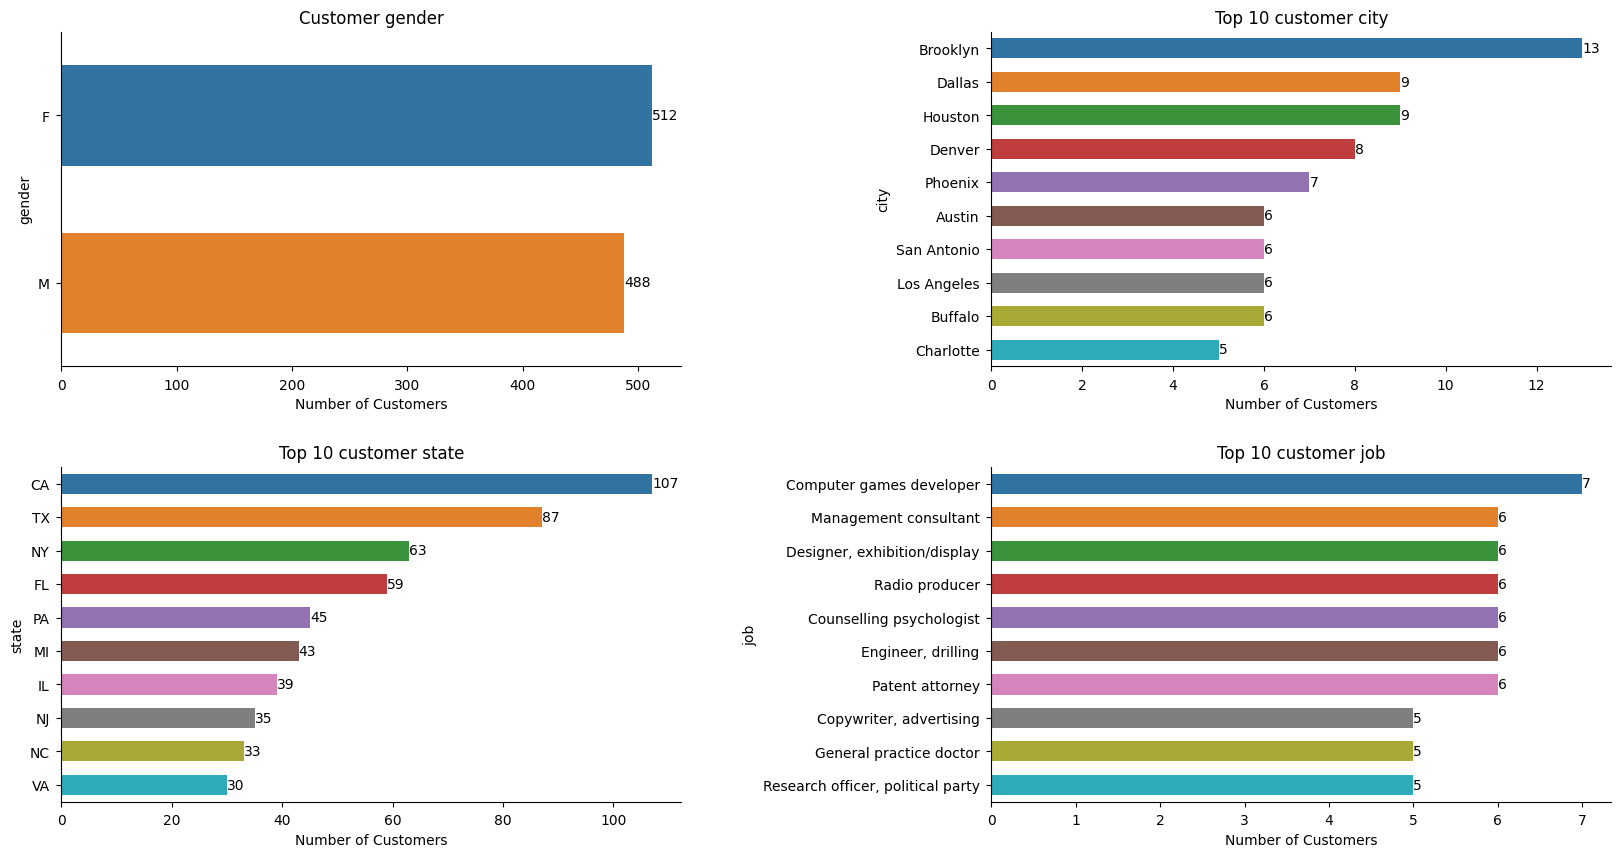

In [22]:
cols = 2
rows = round(len(cus_cate_feats) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10*cols, 5*rows))

row_idx = 0
col_idx = 0

# plot all important features
for feat in cus_cate_feats:
  if col_idx == cols:
    col_idx = 0
    row_idx += 1

  ax = axes[row_idx, col_idx]

  if len(customer_df[feat].unique()) > 10:
        title = f'Top 10 customer {feat}'
  else:
      title = f'Customer {feat}'

  plot_bars(df=customer_df, feat=feat, bar_w=0.6, ax=ax,
          title=title, xlabel='Number of Customers', topk=10,
          ylabel=f'{feat}', mode='subplot')

  col_idx += 1

  # adjust distance between figures
plt.subplots_adjust(wspace=0.5,
                    hspace=0.3)

In [23]:
print('Number of unique cities:', len(customer_df['city'].unique()))
print('Number of unique states:', len(customer_df['state'].unique()))
print('Number of unique jobs:', len(customer_df['job'].unique()))

Number of unique cities: 736
Number of unique states: 51
Number of unique jobs: 507


##### 4.1.2. Numerical Feature

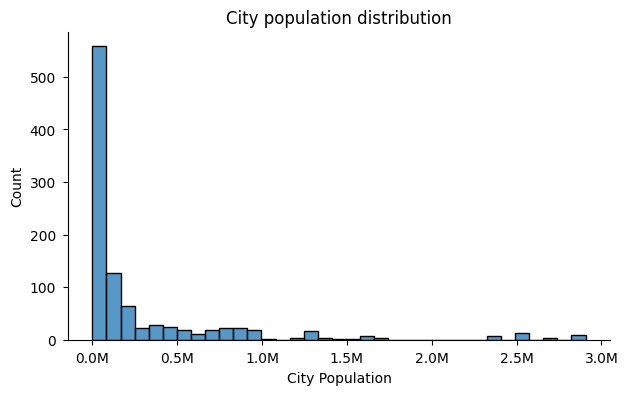

In [24]:
for feat in cus_num_feats:
    plot_hist(df=customer_df, feat=feat, figsize=(7, 4), format_xlabels=True,
              title='City population distribution', xlabel='City Population', ylabel='Count')

Identify numerical feature outliers

In [25]:
data_len = len(customer_df)

for feat in cus_num_feats:
  lower, upper, under_outliers, upper_outliers = count_outliers(customer_df, feat)
  print(feat)
  print(f'Lower: {round(lower, 2)} \t Upper: {round(upper, 2)} \t Under outliers percent: {round(under_outliers/data_len*100, 2)}% \t Upper outliers percent: {round(upper_outliers/data_len*100, 2)}%\n')

city_pop
Lower: -324394.38 	 Upper: 594602.62 	 Under outliers percent: 0.0% 	 Upper outliers percent: 15.6%



##### 4.1.3. Geography Features

In [26]:
customer_df.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num'],
      dtype='object')

In [27]:
state_counts = customer_df.groupby('state')['cc_num'].nunique().reset_index()
state_counts.columns = ['State', 'Customer Count']

fig = px.choropleth(state_counts, locations='State', locationmode='USA-states',
                    color='Customer Count', scope='usa',
                    color_continuous_scale='Blues',
                    title='Number of Customers by State')

fig.show()

In [28]:
fig = px.scatter_geo(customer_df,
                    locationmode='USA-states',
                    scope='usa',
                    lat=customer_df['lat'],
                    lon=customer_df['long'],
                    hover_name="state",
                    title='Customer Distribution by Lat/Long')
fig.show()

**Notes:** Most transactions are in Canada and Texas

##### 4.1.4. Extra Features

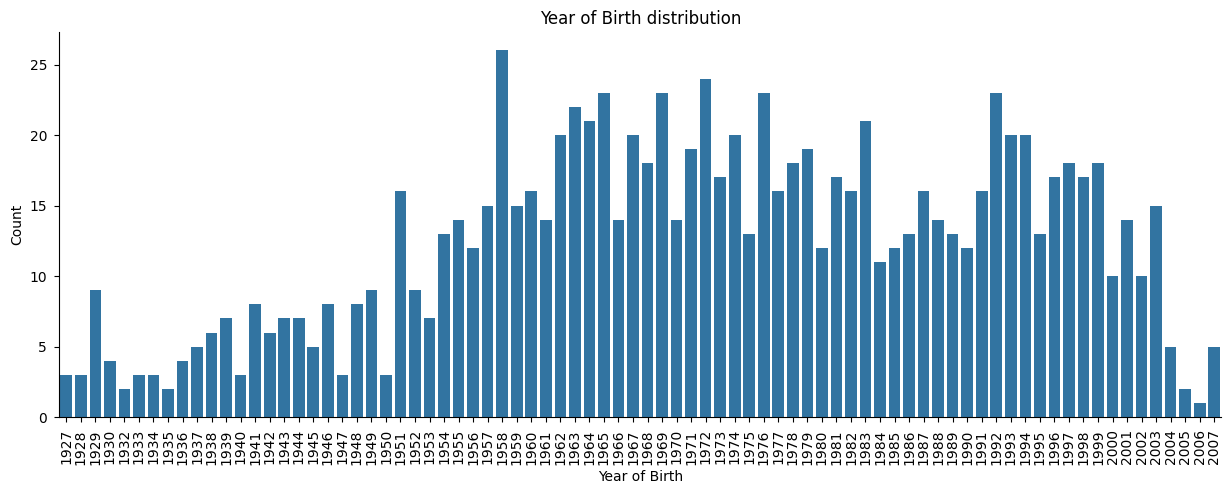

In [29]:
customer_df['year_of_birth'] = customer_df['dob'].apply(lambda date: date[:4])

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=customer_df, x='year_of_birth', order=sorted(customer_df['year_of_birth'].unique()))

plt.xticks(rotation=90)
custom_axes(ax=ax, title='Year of Birth distribution', xlabel='Year of Birth', ylabel='Count')

plt.show()

#### 4.2. Transaction Dataset

In [30]:
print(trans_df.columns)
trans_df.head(3)

Index(['cc_num', 'acct_num', 'trans_num', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long'],
      dtype='object')


,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522
1,4218196001337,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359
2,4218196001337,888022315787,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327


In [31]:
trans_cate_feats = ['category', 'merchant']
trans_num_feats = ['amt']

##### 4.2.1. Categorical Features

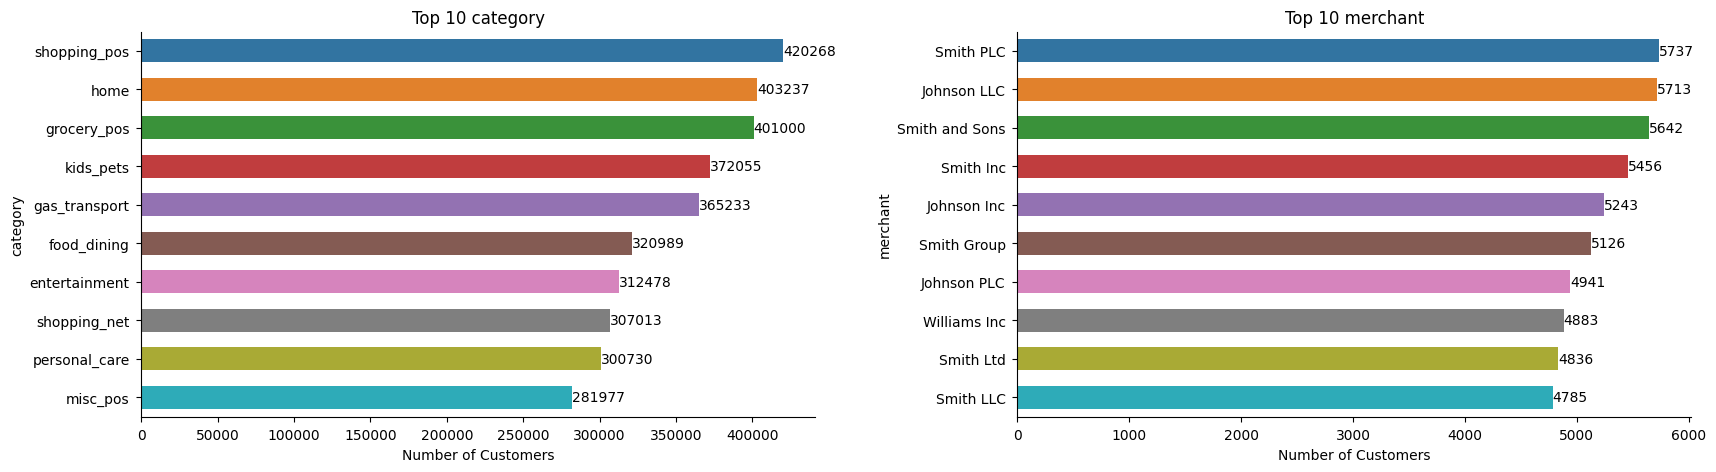

In [32]:
cols = 2
rows = round(len(trans_cate_feats) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10*cols, 5*rows))

row_idx = 0
col_idx = 0

# plot all important features
for feat in trans_cate_feats:
  if col_idx == cols:
    col_idx = 0
    row_idx += 1

  if rows == 1:
    ax = axes[col_idx]
  else:
    ax = axes[row_idx, col_idx]

  plot_bars(df=trans_df, feat=feat, bar_w=0.6, figsize=(8,5),
            title=f'Top 10 {feat}', xlabel='Number of Customers',
            ylabel=f'{feat}', topk=10, mode='subplot', ax=ax)

  col_idx += 1

  # adjust distance between figures
plt.subplots_adjust(wspace=0.3,
                    hspace=0.3)

##### 4.2.2. Numerical Features

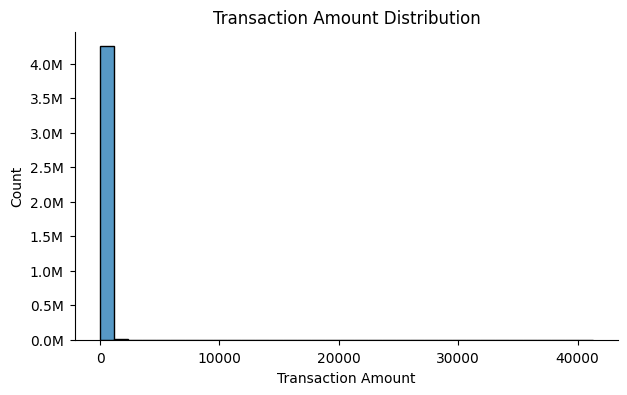

In [33]:
for feat in trans_num_feats:
    plot_hist(df=trans_df, feat=feat, figsize=(7, 4), format_ylabels=True,
              title='Transaction Amount Distribution', xlabel='Transaction Amount', ylabel='Count')

Identify numerical feature outliers

In [34]:
data_len = len(trans_df)

for feat in trans_num_feats:
  lower, upper, under_outliers, upper_outliers = count_outliers(trans_df, feat)
  print(feat)
  print(f'Lower: {round(lower, 2)} \t Upper: {round(upper, 2)} \t Under outliers percent: {round(under_outliers/data_len*100, 2)}% \t Upper outliers percent: {round(upper_outliers/data_len*100, 2)}%\n')

amt
Lower: -99.62 	 Upper: 190.3 	 Under outliers percent: 0.0% 	 Upper outliers percent: 6.24%



##### 4.2.3. Geography Features

In [63]:
fig = px.scatter_geo(trans_df,
                    locationmode='USA-states',
                    scope='usa',
                    lat=trans_df['merch_lat'],
                    lon=trans_df['merch_long'],
                    hover_name="merchant",
                    title='Merchant Distribution by Lat/Long')
fig.show()

##### 4.2.4. Extra Features

In [ ]:
# add new feats
trans_df['trans_date'] = pd.to_datetime(trans_df['unix_time'], unit='s')
trans_df['quarter'] = trans_df['trans_date'].dt.to_period('Q')

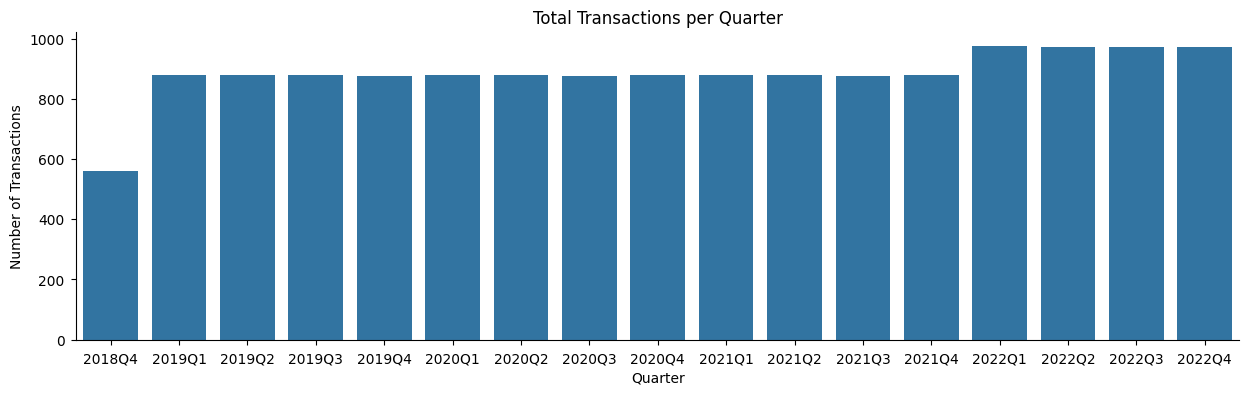

In [65]:
trans_by_quarter = trans_df.groupby('quarter')['cc_num'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(data=trans_by_quarter, x='quarter', y='cc_num')
custom_axes(ax=ax, title='Total Transactions per Quarter', xlabel='Quarter',
            ylabel='Number of Transactions')


### 5. Prepare Data

In [ ]:
trans_df_cleaned = trans_df.copy()

#### 5.1. Add new features

In [ ]:
# add new feats
trans_df_cleaned['trans_date'] = pd.to_datetime(trans_df_cleaned['unix_time'], unit='s')

#### 5.2. Identify and drop outliers

In [ ]:
data_len = len(trans_df_cleaned)

lower, upper, under_outliers, upper_outliers = count_outliers(trans_df_cleaned, 'amt')
print(f'Lower: {round(lower, 2)} \t Upper: {round(upper, 2)} \t Under outliers percent: {round(under_outliers/data_len*100, 2)}% \t Upper outliers percent: {round(upper_outliers/data_len*100, 2)}%\n')

In [ ]:
# drop amt outliers
print('Original number of transactions:', data_len)
trans_df_cleaned = trans_df_cleaned[trans_df_cleaned['amt'] <= upper]
print('New number of transactions:', len(trans_df_cleaned))

#### 5.3. Calculate RFM (Recency - Frequency - Montary) scores for each category

The following function is used to calculate RFM score for each category separately. RFM scores include:
- Recency: The number of days since customers' latest transaction in that category (comparing to the latest transaction in the dataset).
- Frequency: The number of transactions the customer made for that category.
- Montary: The total amount of money the customer spent on that category.

For each customer, categories with no transaction will be assigned with extremely high for recency metric and zeros for frequency and montary metric.

In [ ]:
def calculate_rfm(df, categories):
    '''
    calculate RFM for each category
    '''
    rfm_list = []

    latest_date = df['trans_date'].dt.date.max()
    print('Latest date:', latest_date)

    for cat in categories:
        df_cat = df[df['category'] == cat]
        rfm_table = df_cat.groupby('cc_num').agg({
            'trans_date': lambda x: (latest_date - x.max().date()).days,
            'trans_num': lambda x: len(x),
            'amt': lambda x: x.sum()
            })
        # change type
        rfm_table['trans_date'] = rfm_table['trans_date'].astype(int)
        # rename columns
        rfm_table.rename(columns={
            'trans_date': f'recency_{cat}',
            'trans_num': f'freq_{cat}',
            'amt': f'montary_{cat}'
        }, inplace=True)
        rfm_list.append(rfm_table)

    recency_cols = [f'recency_{cat}' for cat in categories]

    final = pd.concat(rfm_list, axis=1)
    # recency for category with no trans (assign extreme value)
    final[recency_cols] = final[recency_cols].fillna(10000)
    # montary and freq for category with no trans
    final.fillna(0, inplace=True)
    return final


In [ ]:
latest_date = trans_df_cleaned['trans_date'].dt.date.max()

rfm_df = calculate_rfm(trans_df_cleaned, trans_df_cleaned['category'].unique())
print(rfm_df.shape)
rfm_df

#### 5.4. Join Data and Feature Selection

After lots of experiments, I decided to use the feature set that includes:
- Customer RFM scores for each category
- Customer city

In [ ]:
'''
Join 2 datasets
'''
df_merged = rfm_df.reset_index().merge(customer_df[['cc_num', 'lat', 'long', 'job', 'gender', 'dob', 'city', 'state', 'zip']], how='left', on='cc_num')
df_merged = df_merged.set_index('cc_num')

In [ ]:
df_merged.shape

In [ ]:
'''
Preprocess data and filter necessary features
'''
categorical_preprocessor = OrdinalEncoder()
numerical_preprocessor = StandardScaler()

cate_feats = ['city']
num_feats = list(rfm_df.columns)

X = df_merged[cate_feats + num_feats]

preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, cate_feats),
        ("numerical", numerical_preprocessor, num_feats)
    ])

preprocess_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
X_processed = preprocess_pipeline.fit(X).transform(X)

### 6. Split Dataset

Since this is an unsupervised learning problem. No data splits are performed. Instead, we will use all the available data to to build a reasonable clustering model.

### 7. Baseline Model

In this section, a dummy clustering model will be created to randomly assign customers into different groups. Let's assume that the model will randomly assign our customers into 3 different groups.

Two evaluation metrics will be used to evaluate the model performance:
- Silhoutte Score: The score indicates how well clusters are formed. It considers both point distances within a cluster and between different clusters. The score have range from -1 to 1, where -1 indicates the worst result and 1 indicate a perfect clustering.
- Davies-Bouldin Index: It measures the average ratio of the within-cluster scatter to the between-cluster separation. It aims to find well-separated clusters with minimal internal variation. The lower the score is, the better the model is.

In [ ]:
'''
create a random cluster ID for each customer
'''
random_clusters = [random.randint(0, 2) for i in range(len(X_processed))]
len(random_clusters)

In [ ]:
silhouette_baseline = silhouette_score(X_processed, random_clusters)
silhouette_baseline

Negative score indicate very poor clustering.

### 8. Train Machine Learning Model

After experimenting different models (KMeans, DBSCAN, Hiearchy Clustering, etc) and feature engineering techniques (feature encoding, time series transformation, PCA, etc.), the best model for clustering is KMeans clustering with PCA to reduce the number of feature dimensions.

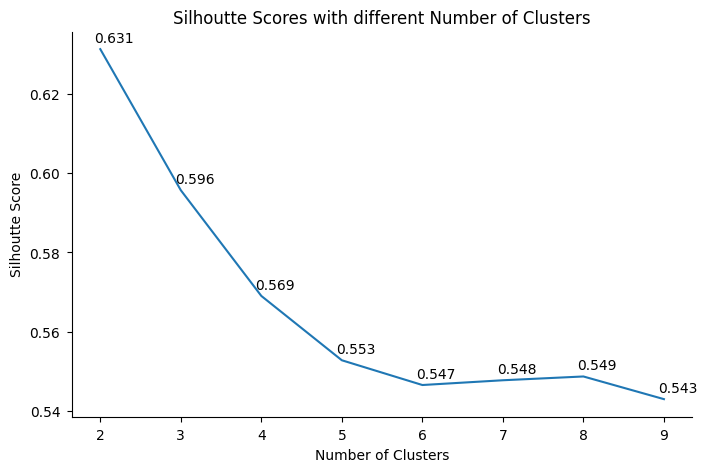

In [67]:
'''
Train and evaluate Kmeans clustering with different number of clusters
'''

# apply PCA to reduce dimensions
n_components = 2
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(X_processed)

silhouette_scores = []

for k in range(2, 10):  # Choose a range of k values
  model = KMeans(n_clusters=k, random_state=42)
  model.fit(pca_data)

  silhouette_avg = silhouette_score(pca_data, model.labels_)
  silhouette_scores.append(silhouette_avg)

df_sil_scores = pd.DataFrame({'num_clusters': range(2, 10), 'score': silhouette_scores})

# plot scores
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=df_sil_scores, x='num_clusters', y='score')

# add score value to charts
for i, row in df_sil_scores.iterrows():
  x = row['num_clusters']
  y = row['score']
  plt.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(10, 5), ha='center')  # Customize positioning and format

custom_axes(ax=ax, title='Silhoutte Scores with different Number of Clusters',
            xlabel='Number of Clusters', ylabel='Silhoutte Score')


As can be seen from above, Kmeans performs the best when the number of cluster is 2.

### 9. Assess Model Performance

#### 9.1. Best Model Performance

In [69]:
'''
Create new model with n_clusters=2
'''
model = KMeans(n_clusters=2, random_state=42)
model.fit(pca_data)

silhouette_avg = round(silhouette_score(pca_data, model.labels_), 3)
print('Silhoutte Score for KMeans with 2 clusters:', silhouette_avg)

Silhoutte Score for KMeans with 2 clusters: 0.631


In [70]:
# Assuming your fitted model is named 'model' and data is 'X'
dbi_score = round(davies_bouldin_score(pca_data, model.labels_), 3)
print("Davies-Bouldin Index for KMeans with 2 clusters:", dbi_score)

Davies-Bouldin Index for KMeans with 2 clusters: 0.491


**Insights**: The model achieved 0.631 Silhoutte Score and 0.491 DBI score, which indicates a reasonable clustering. The clustering might not be the best, but can show the hidden trends between customer groups.

#### 9.2. Model Result Intepretation

We then analyze deeper to understand the hidden patterns among customer groups

In [ ]:
df_merged['cluster'] = model.labels_

In [72]:
'''
Clustering visualization
'''

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Cluster'

fig = px.scatter_matrix(
    pca_data,
    color=model.labels_,
    dimensions=range(2),
    labels=labels,
    title=f'Customer Segmentation Clusters by PCA (Total Explained Variance: {total_var:.2f}%)',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [73]:
'''
Customer Groups distribution by lat/long
'''
fig = px.scatter_geo(df_merged.reset_index(),
                    locationmode='USA-states',
                    scope='usa',
                    lat=df_merged['lat'],
                    lon=df_merged['long'],
                    hover_name="city",
                    color='cluster',
                    title='Customer Group Distribution by Lat/Long')
fig.show()

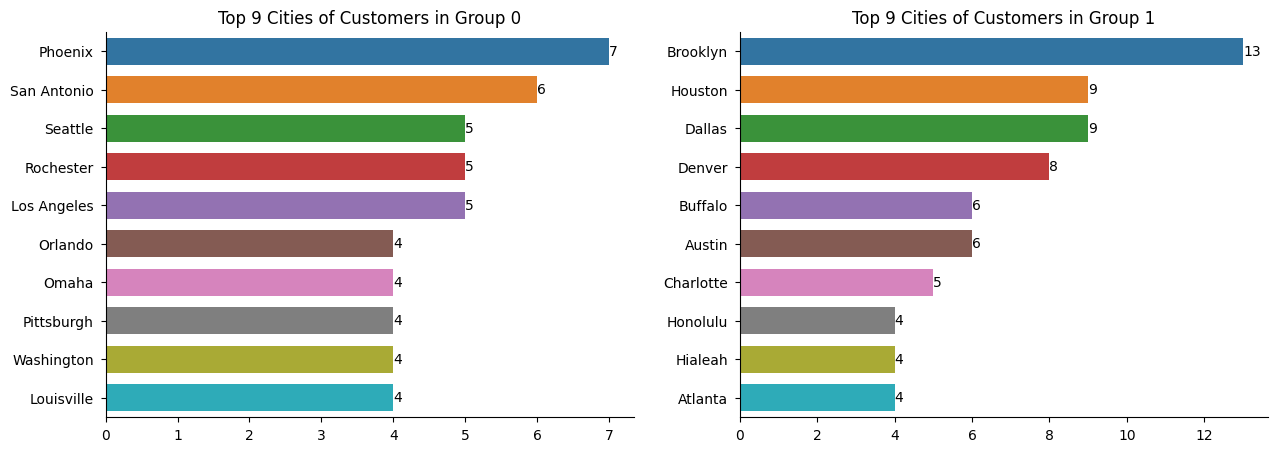

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_bars(df=df_merged[df_merged['cluster'] == 0], feat='city', topk=10,
          title=f'Top {k} Cities of Customers in Group 0', ax=axes[0], mode='subplot',
          bar_w=0.7)

plot_bars(df=df_merged[df_merged['cluster'] == 1], feat='city', topk=10,
          title=f'Top {k} Cities of Customers in Group 1', ax=axes[1], mode='subplot',
          bar_w=0.7)

The customers in 2 groups mainly located in different cities.

In [ ]:
'''
Using statistical test to identify important features with significant difference among customer groups.
'''
def identify_important_features(data, cluster_labels, num_feats):
  # Identifies features with significant differences between clusters using ANOVA.

  numerical_features = num_feats
  feature_importance = pd.DataFrame(columns=["Feature", "F-statistic", "p-value"])

  for feature in numerical_features:
    # Perform ANOVA F-test
    F_statistic, p_value = f_classif(data[[feature]], cluster_labels)

    feature_importance = pd.concat([feature_importance, pd.DataFrame({
        "Feature": [feature],
        "F-statistic": [F_statistic[0]],
        "p-value": [p_value[0]],
    })])

  return feature_importance

# Identify features with significant difference (low p-value)
important_features_df = identify_important_features(df_merged, model.labels_,
                                                 num_feats=num_feats)

# Set p value to 0.1
print("Number of features with significant difference (p-value < 0.1):",
      len(important_features_df[important_features_df["p-value"] < 0.1]))
print(important_features_df[important_features_df["p-value"] < 0.1])

In [ ]:
important_feats = important_features_df[important_features_df["p-value"] < 0.1]['Feature'].unique()
important_feats

In [ ]:
important_feats = important_features_df[important_features_df["p-value"] < 0.1]['Feature'].unique()

ordered_important_feats = [
    'recency_entertainment', 'freq_entertainment', 'montary_entertainment',
    'recency_food_dining', 'freq_food_dining', 'montary_food_dining',
    'recency_travel', 'freq_travel', 'montary_travel',
    'recency_misc_pos', 'freq_misc_pos',  'freq_grocery_pos',
    'recency_shopping_pos', 'recency_shopping_net', 'recency_personal_care',
    'recency_health_fitness', 'recency_home', 'recency_kids_pets'
]

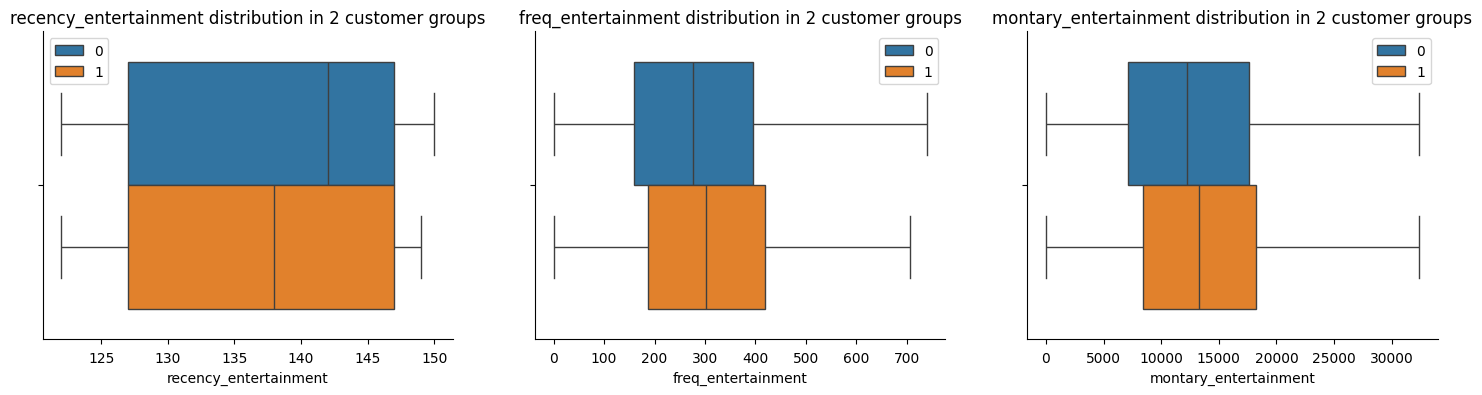

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

idx = 0

for feat in ['recency_entertainment', 'freq_entertainment', 'montary_entertainment']:
  sns.boxplot(data=df_merged, x=feat, hue=model.labels_, showfliers=False,
              ax=axes[idx])
  custom_axes(ax=axes[idx], xlabel=feat, title=f'{feat} distribution in 2 customer groups')
  idx += 1

**Insights**:
- Customers in Group 1 tend to pay more money for entertainment. They also pay for it more frequently and recently compared to those in the other group.
- The Marketing Team should send emails that promote entertainment category for customers in this group.

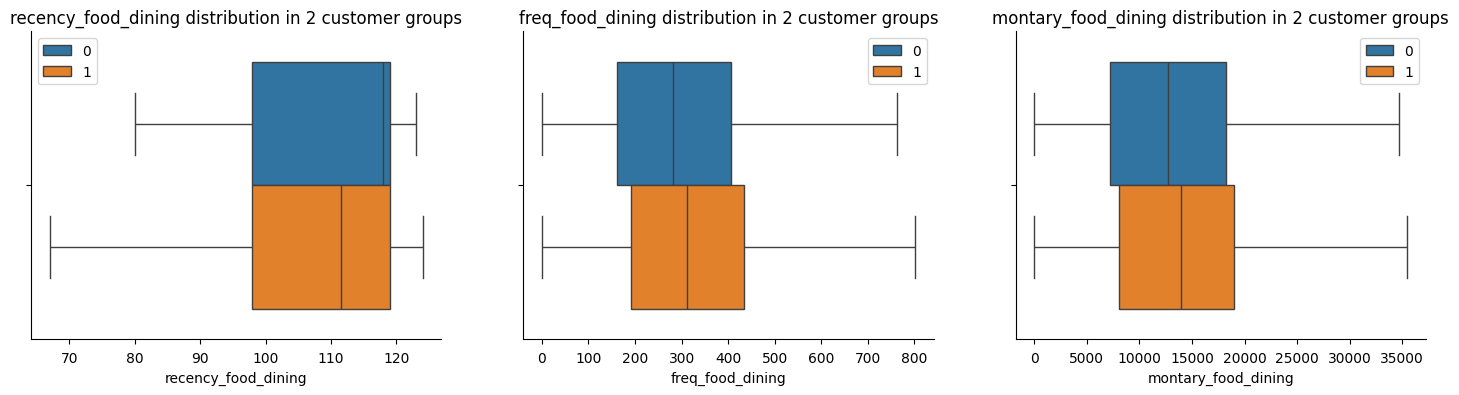

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

idx = 0

for feat in ['recency_food_dining', 'freq_food_dining', 'montary_food_dining']:
  sns.boxplot(data=df_merged, x=feat, hue=model.labels_, showfliers=False,
              ax=axes[idx])
  custom_axes(ax=axes[idx], xlabel=feat, title=f'{feat} distribution in 2 customer groups')
  idx += 1

**Insights**:
- Customers in Group 1 tend to pay more money for food dining. They also pay for it more frequently and recently compared to those in the other group.
- The Marketing Team should send emails that promote the food dining category for customers in this group.

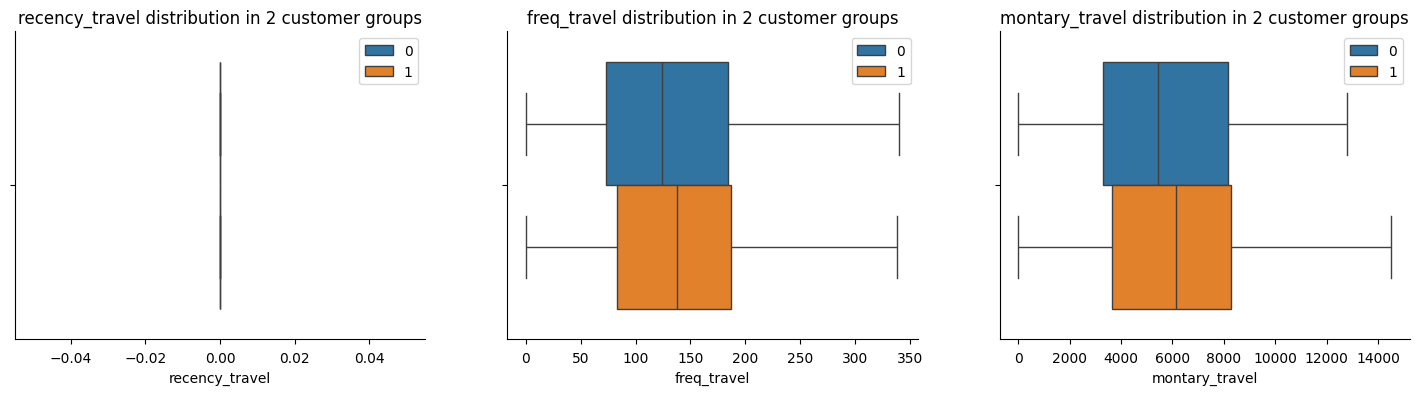

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

idx = 0

for feat in ['recency_travel', 'freq_travel', 'montary_travel']:
  sns.boxplot(data=df_merged, x=feat, hue=model.labels_, showfliers=False,
              ax=axes[idx])
  custom_axes(ax=axes[idx], xlabel=feat, title=f'{feat} distribution in 2 customer groups')
  idx += 1

**Insights**:
- Customers in Group 1 tend to pay more money for travelling. They also pay for it more frequently compared to those in the other group.
- The Marketing Team should send emails that promote the travelling category for customers in this group.

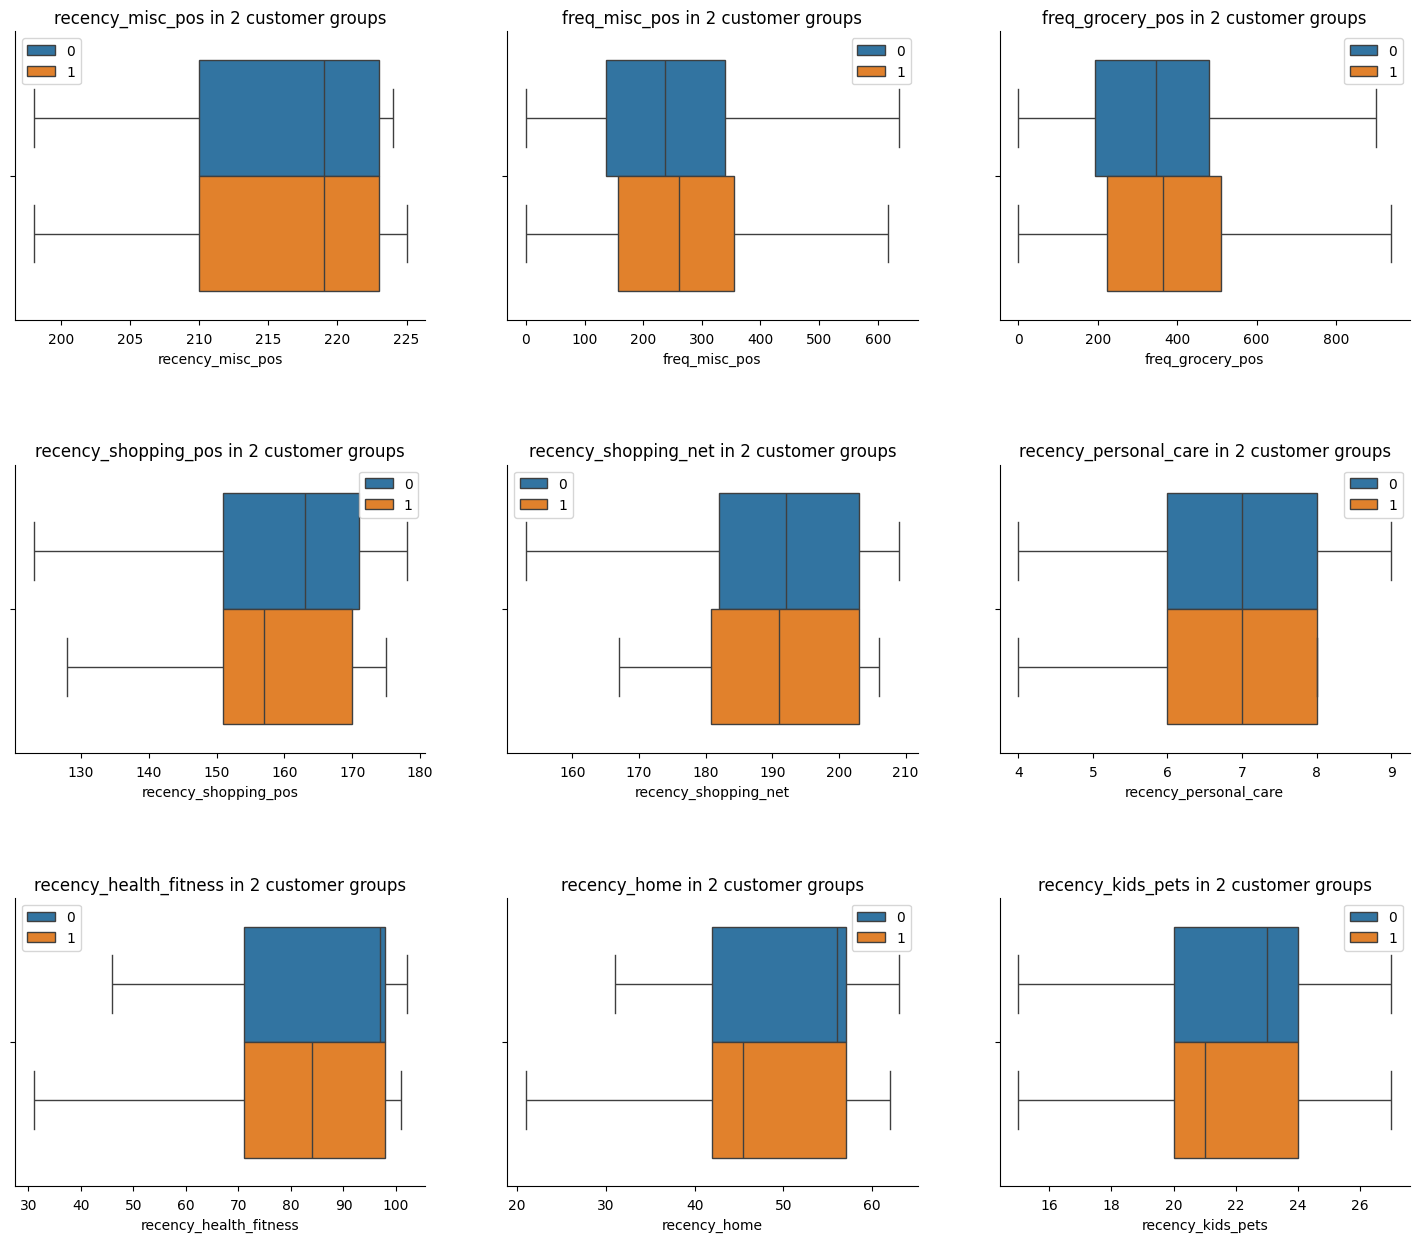

In [79]:
# other important features apart from above visualized features
important_set = ['recency_misc_pos', 'freq_misc_pos',  'freq_grocery_pos',
    'recency_shopping_pos', 'recency_shopping_net', 'recency_personal_care',
    'recency_health_fitness', 'recency_home', 'recency_kids_pets']

cols = 3
rows = round(len(important_set) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

row_idx = 0
col_idx = 0

# plot all important features
for feat in important_set:
  if col_idx == cols:
    col_idx = 0
    row_idx += 1

  ax = axes[row_idx, col_idx]

  sns.boxplot(data=df_merged, x=feat, hue=model.labels_, showfliers=False, ax=ax)
  custom_axes(ax=ax, xlabel=feat, title=f'{feat} in 2 customer groups')

  col_idx += 1

  # adjust distance between figures
plt.subplots_adjust(wspace=0.2,
                    hspace=0.5)

Insights:
- Overall, the customers in group 1 tend to be more active than those in the other group (more recent transactions for categories such as shopping, fitness, home and kids pets). This can indicate new spending trends of these customers the next years.
- The Marketing Team should tailor the marketing emails for these customers based on their new spending trends.

### Conclusion

By using **KMean Clustering** with stastical test for result intepretation, we can highlight a customer group (Group 1) which are likely potential customers in some specific categories.

To be more specific, customers in this group tend to **spend more money, more frequently and recently in entertainment, food dining and travelling** compared to others. They also more likely to spend on fitness, home and kids/pets due to their compared to other customers.

Overall, these customers seem to care more about their life style and experience. Marketing Team should tailor the marketing emails sent to them more about these categories to gain attraction and success likelihood.